### A3

In [93]:
import numpy as np
import tensorflow as tf

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

### 1.1

1. You can implement the squared euclidean distance function between a B x D matrix X and a K x D matrix Y as
$(X-Y)^T(X-Y) = XX^T -2XY^T + YY^T$. This is equivalent to expanding the product of the differences.

2.

In [2]:
x_np = np.array([[1, 1], [2, 2]]).astype("float32")
x_np

array([[ 1.,  1.],
       [ 2.,  2.]], dtype=float32)

In [3]:
y_np = np.array([[1, 1], [2, 2], [3, 3]]).astype("float32")
y_np

array([[ 1.,  1.],
       [ 2.,  2.],
       [ 3.,  3.]], dtype=float32)

In [4]:
X = tf.Variable(x_np)

In [5]:
Y = tf.Variable(y_np)

In [6]:
def matDistance(X, Y):
    # X is N X D
    # Y is K x D
    
    assert X.get_shape()[1] == Y.get_shape()[1]
    
    Y_T = tf.transpose(Y)
    
    # Element-wise multiplication
    XX = tf.mul(X, X) 
    YY = tf.mul(Y_T, Y_T)
    
    # Sum XX along row, and YY along column
    XX = tf.reshape(tf.reduce_sum(XX, 1), [-1, 1]) # N x 1
    YY = tf.reshape(tf.reduce_sum(YY, 0), [1, -1]) # 1 x K
    XY = tf.mul(2.0, tf.matmul(X, Y_T))            # N x K
    
    return XX - XY + YY

In [78]:
dist = matDistance(X, Y)

In [81]:
init = tf.initialize_all_variables()

with tf.Session() as sess:
    sess.run(init)
    v = sess.run(dist)    
    print v # will show you your variable.

[[ 0.  2.  8.]
 [ 2.  0.  2.]]


### 1.2

1. The loss function is not convex. The algorithm is guaranteed to converge, but may converge to a local minima, not a global one. Mathematically, the loss function is not convex because it is not defined on a convex set. Intuitively, we can see this in a trivial example, where the solution is non-unique. Consider the datapoints in the cartesian plane {(0, 0), (0, 2), (2, 2), (2, 0)}. For K = 2, we have a local minima for $\mu$ = {(0, 1), (2, 1)} and another for $\mu$ = {(1, 0), (1, 2)}. The existence of multiple local minima imples the loss function is not convex.

In [8]:
data = np.load('data2D.npy')

In [10]:
data.shape

(10000, 2)

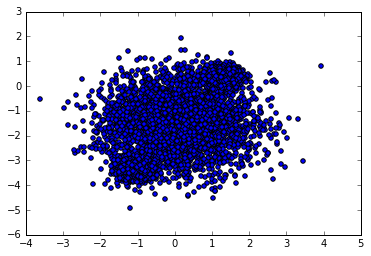

In [15]:
plt.scatter(data.T[0], data.T[1])

In [17]:
data.shape

(10000, 2)

In [16]:
def mu_var(shape):
  initial = tf.truncated_normal(shape, stddev=0.25)
  return tf.Variable(initial)

In [85]:
def k_means(K, data, learning_rate, num_epochs, validation_percent):
    N = data.shape[0]
    D = data.shape[1]
    
    X = tf.placeholder("float", shape=(data.shape)) # N x D
    mu = mu_var((K, D)) # K x D
    
    dist = matDistance(X, mu) # N x K
    
    # Take the minimum across all K
    min_dist = tf.reduce_min(dist, 1) # N x 1
    
    # Sum across all training examples
    L = tf.reduce_sum(min_dist, 0)
    
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train_op = optimizer.minimize(L)
    
    # Determine cluster assignments
    assg = tf.argmin(dist, 1)
    
    init = tf.initialize_all_variables()
    
    loss_results = np.zeros(num_epochs)
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            loss, _ = sess.run([L, train_op], feed_dict={X: data})
            loss_results[epoch] = loss
            
        cluster_assignments = sess.run(assg, feed_dict={X: data})
        
    return loss_results, cluster_assignments

In [99]:
def plot_loss(num_epochs, loss):
    plt.plot(np.arange(num_epochs), loss)
    plt.title('Loss vs Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

In [160]:
def plot_scatter(data, cluster_assg, K):
    col_it = iter(plt.cm.rainbow(np.linspace(0,1,K)))
    for i in range(K):
        cluster_data = data[cluster_assg == i].T
        plt.scatter(cluster_data[0], cluster_data[1], color=next(col_it))
    plt.show()

2.

In [138]:
num_epochs = 500
learning_rate = 0.01
K = 3

In [139]:
loss_results, cluster_assg = k_means(K, data, learning_rate, num_epochs)
print 'Final Loss: ', loss_results.min()

Final Loss:  5162.55859375


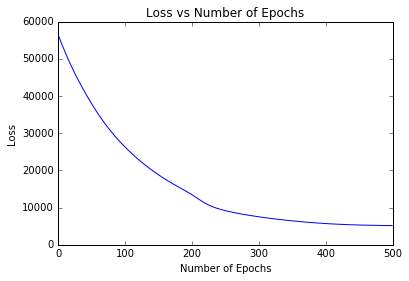

In [140]:
plot_loss(num_epochs, loss_results)

3.

K = 1
Final Loss:  38453.3515625
% of points in each cluster:  {0: 100.0}


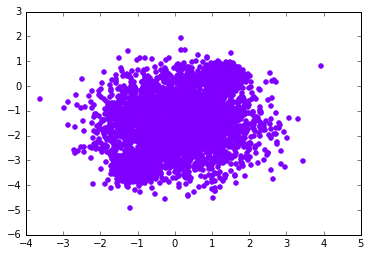

K = 2
Final Loss:  9204.3828125
% of points in each cluster:  {0: 50.54, 1: 49.46}


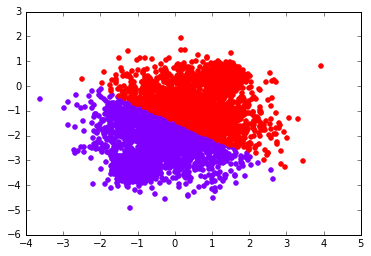

K = 3
Final Loss:  5156.04638672
% of points in each cluster:  {0: 37.88, 1: 23.51, 2: 38.61}


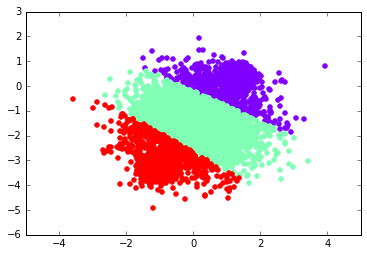

K = 4
Final Loss:  3387.82055664
% of points in each cluster:  {0: 13.43, 1: 12.02, 2: 37.34, 3: 37.21}


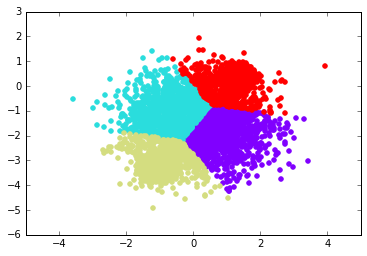

K = 5
Final Loss:  2922.484375
% of points in each cluster:  {0: 9.29, 1: 10.22, 2: 36.61, 3: 7.82, 4: 36.06}


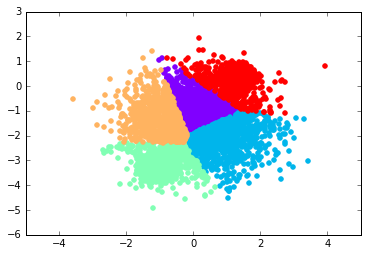

In [162]:
for k in range(1, 6):
    print 'K = {}'.format(k)
    
    loss_results, cluster_assg = k_means(k, data, learning_rate, num_epochs)
    print 'Final Loss: ', loss_results.min()
    
    samples_per_cluster = dict(Counter(cluster_assg))
    samples_per_cluster.update((x, y * 100.0 / data.shape[0]) for x, y in samples_per_cluster.items())
    print '% of points in each cluster: ', samples_per_cluster
    
    plot_scatter(data, cluster_assg, k)

I would argue that 4 clusters is the best. K = 5 gives the lowest loss, but K = 4 isn't far behind. For K = 5, it looks like the upper two clusters aren't that different, as their centroids aren't very far apart. Also, three of the clusters have very low membership, while the other two contain over 70% of the samples. For K = 3 and below, the clusters look like they are effective, as they each contain points that are different enough from each other, and the centroids are reasonably spaced out. They also have evenly distributed cluster assignments, but their loss is too high. This is because each cluster contains points that are fairly far from the centroid. For this reason, I would argue that K = 4 is a good compromise between the two, with a low loss, and four prototypes that represent their assigned training samples fairly well.

4.